In [1]:
import torch
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
solver = scipy.integrate.solve_ivp

In [2]:
import torch.nn as nn
device = 'cpu'

In [3]:
class MLPC(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLPC, self).__init__()
    self.l1 = nn.Linear(input_size,hidden_size)
    self.l2 = nn.Linear(hidden_size,hidden_size)
    self.l3 = nn.Linear(hidden_size,output_size)
    self.input_size = input_size
  
  def forward(self,x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x
  
  def jac(self, x):
    x = x.requires_grad_(True)
    with torch.enable_grad():
      u = self(x)
      #jac = torch.autograd.functional.jacobian(MLPU.forward(self,x), x, create_graph=True)
      jac = torch.zeros((x.shape[0], self.input_size, self.input_size)).to(device)
      for idx in range(self.input_size):
        jac[:,idx,:] = torch.autograd.grad(u[:,idx].sum(), x, create_graph=True)[0]
    return jac

In [4]:
class hamiltonian(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(hamiltonian,self).__init__()
    self.l1 = nn.Linear(input_size,hidden_size)
    self.l2 = nn.Linear(hidden_size,hidden_size)
    self.l3 = nn.Linear(hidden_size,output_size)
  
  def forward(self,x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x

  def grad(self,x):
    x = x.requires_grad_(True)
    with torch.enable_grad():
      hamiltonian = self(x)
      gradient = torch.autograd.grad(hamiltonian.sum(),x,create_graph=True,retain_graph=True)
    return gradient[0]
  

In [5]:
input_size = 4
hidden_size = 200
output_size = 1

num_trials = 10

In [6]:
M = 100 * 1
tend = 5.0 * 1
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

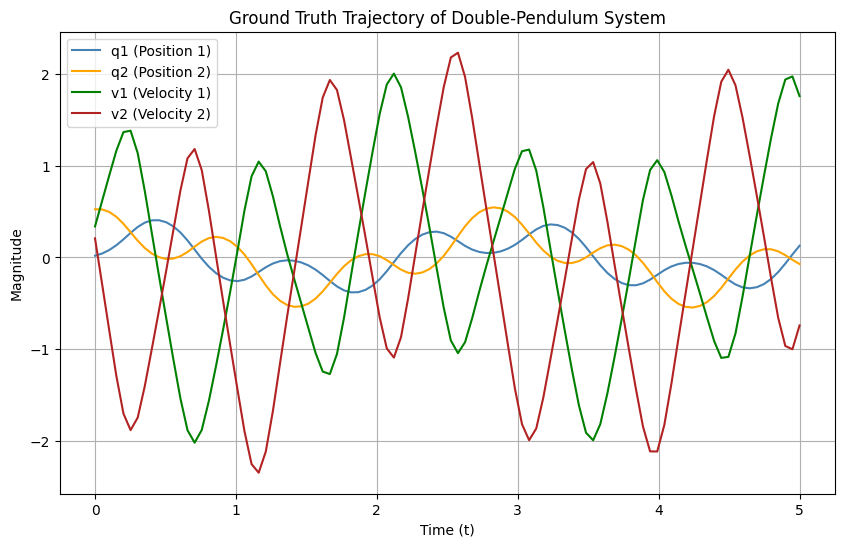

In [7]:
# Ground truth
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

# # equations of motion
# def func(t, state):
#   cosv = np.cos(state[0]-state[1])
#   sinv = np.sin(state[0]-state[1])
#   dvdt = np.zeros_like(state)
#   dvdt[0] = state[2]
#   dvdt[1] = state[3]
#   dvdt[2] = (g*(np.sin(state[1])*cosv - m/m2*np.sin(state[0])) - (l1*state[2]*state[2]*cosv + l2* state[3]*state[3])*sinv) / (l1*(m/m2-cosv*cosv))
#   dvdt[3] = (g*m/m2*(np.sin(state[0])*cosv - np.sin(state[1])) + sinv * (l1*state[2]*state[2]*m/m2 + l2* state[3]*state[3]*cosv)) / (l2*(m/m2-cosv*cosv))
#   return dvdt

def func_reordered(t, state):
    q1 = state[0] # theta1
    v1 = state[1] # omega1
    q2 = state[2] # theta2
    v2 = state[3] # omega2
    
    cosv = np.cos(q1 - q2) # cos(theta1 - theta2)
    sinv = np.sin(q1 - q2) # sin(theta1 - theta2)
    m = m1 + m2
    
    dvdt = np.zeros_like(state)

    # dq1/dt = v1
    dvdt[0] = v1
    
    # dq2/dt = v2
    dvdt[2] = v2

    # dv1/dt = ddot(theta1)
    num1 = (g * (np.sin(q2) * cosv - (m/m2) * np.sin(q1)) 
            - (l1 * v1**2 * cosv + l2 * v2**2) * sinv)
    den1 = l1 * ((m/m2) - cosv**2)
    dvdt[1] = num1 / den1
    
    # dv2/dt = ddot(theta2)
    num2 = (g * (m/m2) * (np.sin(q1) * cosv - np.sin(q2)) 
            + sinv * (l1 * v1**2 * (m/m2) + l2 * v2**2 * cosv))
    den2 = l2 * ((m/m2) - cosv**2)
    dvdt[3] = num2 / den2
  
    return dvdt


# state = []
# for i in range(1):
#   s = (0.01825532, 0.52412613, 0.33688556, 0.20706259 )
#   state.append(s)

state = []
for i in range(1):
  s = (0.01825532, 0.33688556, 0.52412613, 0.20706259 )
  state.append(s)

# for i in range(1):
#   sol = solver(func, [0, tend], state[i], t_eval=t_eval)
#   tval = sol['t']
#   q1 = sol['y'][0]
#   q2 = sol['y'][1]
#   v1 = sol['y'][2]
#   v2 = sol['y'][3]
#   ax=plt.subplot()
#   ax.set_ylim([-3,3])
#   ax.plot(tval, q1, 'steelblue')
#   ax.plot(tval, v1, 'orange')
#   ax.plot(tval, q2, 'g')
#   ax.plot(tval, v2, 'firebrick')
#   plt.show()

for i in range(1):
  sol = solver(func_reordered, [0, tend], state[i], t_eval=t_eval)
  tval = sol['t']
    
  q1 = sol['y'][0] # theta 1
  v1 = sol['y'][1] # omega 1
  q2 = sol['y'][2] # theta 2
  v2 = sol['y'][3] # omega 2
  
  plt.figure(figsize=(10, 6))
  plt.plot(tval, q1, 'steelblue', label='q1 (Position 1)')
  plt.plot(tval, q2, 'orange', label='q2 (Position 2)')
  plt.plot(tval, v1, 'g', label='v1 (Velocity 1)')
  plt.plot(tval, v2, 'firebrick', label='v2 (Velocity 2)')
  plt.xlabel('Time (t)')
  plt.ylabel('Magnitude')
  plt.title('Ground Truth Trajectory of Double-Pendulum System')
  plt.legend()
  plt.grid(True)
  plt.show()

In [8]:
true_res = []

for i in range(q1.shape[0]):
    true_res.append(np.array([q1[i], v1[i], q2[i], v2[i]]))

true_res = np.array(true_res)
print('true_res:', true_res.shape)

true_res: (100, 4)


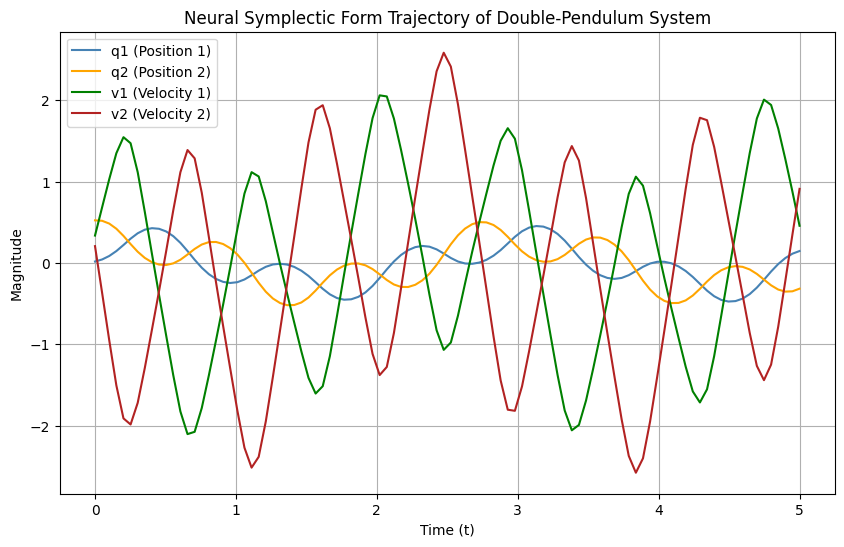

In [9]:
# simulation
# parameters
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

# state = []
# for i in range(1):
#   s = (0.01825532, 0.52412613, 0.33688556, 0.20706259 )
#   state.append(s)

state = []
for i in range(1):
  s = (0.01825532, 0.33688556, 0.52412613, 0.20706259 )
  state.append(s)

trial = 9

c_nn = MLPC(input_size, hidden_size, input_size).to(device)
h_nn = hamiltonian(input_size, hidden_size, output_size).to(device)

c_nn.load_state_dict(torch.load("./model/sym_c_dp_2t_{}".format(trial), map_location="cpu"))
c_nn.eval()
h_nn.load_state_dict(torch.load("./model/sym_h_dp_2t_{}".format(trial), map_location="cpu"))
h_nn.eval()
x0 = state[0]

import pandas as pd
A = pd.read_csv("./data/A.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/B.csv", header=None, dtype=np.float32)

A = np.asmatrix(A)
B = np.asmatrix(B)
A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
h_nn.cpu()
c_nn.cpu()

def fvec_np(x, t): 
  tx = torch.tensor(x, dtype=torch.float).unsqueeze(0)  
  x = torch.matmul(tx, torch.inverse(B))
  output = h_nn.grad(x)
  jac = c_nn.jac(x)
  jac_t = torch.transpose(jac,1,2)
  M_t = jac - jac_t
  M_inv_t = torch.inverse(M_t).squeeze(1).cpu()

  output = output.unsqueeze(2)
  output = torch.matmul(M_inv_t, output)
  output = torch.matmul(A, output)
  output = output.squeeze(2)
  output = output.squeeze(0)
  return output.detach().cpu().numpy()


res = scipy.integrate.odeint(fvec_np, x0, t_eval)

# plt.figure(figsize=(10, 6))
# plt.plot(t_eval,res[:,0], 'steelblue', label='q1 (Position 1)')
# plt.plot(t_eval,res[:,1], 'orange', label='q2 (Position 2)'), 
# plt.plot(t_eval,res[:,2], 'g', label='v1 (Velocity 1)')
# plt.plot(t_eval,res[:,3], 'firebrick', label='v2 (Velocity 2)')
# plt.xlabel('Time (t)')
# plt.ylabel('Magnitude')
# plt.title('HNN Trajectory of Spring-Mass System')
# plt.legend()
# plt.grid(True)
# plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_eval,res[:,0], 'steelblue', label='q1 (Position 1)')
plt.plot(t_eval,res[:,2], 'orange', label='q2 (Position 2)'), 
plt.plot(t_eval,res[:,1], 'g', label='v1 (Velocity 1)')
plt.plot(t_eval,res[:,3], 'firebrick', label='v2 (Velocity 2)')
plt.xlabel('Time (t)')
plt.ylabel('Magnitude')
plt.title('Neural Symplectic Form Trajectory of Double-Pendulum System')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
M1, M2, L1, L2, G = m1, m2, l1, l2, g

def Hamiltonian_ftn_double_pendulum(state):
    theta1 = state[0]
    theta2 = state[2]
    omega1 = state[1]
    omega2 = state[3]

    T1 = 0.5 * M1 * (L1 * omega1)**2
    T2 = 0.5 * M2 * (
        (L1 * omega1)**2 + 
        (L2 * omega2)**2 + 
        2 * L1 * L2 * omega1 * omega2 * np.cos(theta1 - theta2)
    )
    kinetic_energy = T1 + T2

    V1 = -M1 * G * L1 * np.cos(theta1)
    V2 = -M2 * G * (L1 * np.cos(theta1) + L2 * np.cos(theta2))
    potential_energy = V1 + V2

    return (kinetic_energy + potential_energy)

def true_energy(trajectory):
    energies = []
    for state_t in trajectory:
        energies.append(Hamiltonian_ftn_double_pendulum(state_t))

    return np.array(energies)

In [11]:
def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = h_nn.forward(x).squeeze(0)
  return ne.detach().cpu().numpy()


Hmodel_sym_x = net_energy(res, t_eval).reshape((M))
Hmodel_true_x = net_energy(true_res, t_eval).reshape((M))

Htrue_sym_x = true_energy(res).reshape((M))
Htrue_true_x = true_energy(true_res).reshape((M))

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_2x2_analysis(true_res, res, t_eval, Htrue_true_x, Htrue_hnn_x, Hmodel_true_x, Hmodel_hnn_x):
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    tpad = 7

    # --- Top Left Plot (0, 0): Ground Truth Trajectory ---
    axes[0, 0].plot(t_eval, true_res[:, 0], 'steelblue', label='q1 (Position 1)')
    axes[0, 0].plot(t_eval, true_res[:, 2], 'g', label='q2 (Position 2)')
    axes[0, 0].plot(t_eval, true_res[:, 1], 'orange', label='v1 (Velocity 1)')
    axes[0, 0].plot(t_eval, true_res[:, 3], 'firebrick', label='v2 (Velocity 2)')
    axes[0, 0].set_ylabel('Magnitude')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylim([-3,3])
    axes[0, 0].set_title('Ground Truth Trajectory')
    axes[0, 0].legend(loc='upper right', fontsize=8)
    axes[0, 0].grid(True)

    # --- Top Right Plot (0, 1): Model Prediction Trajectory ---
    axes[0, 1].plot(t_eval, res[:, 0], 'steelblue', label='q1 (Position 1)')
    axes[0, 1].plot(t_eval, res[:, 2], 'g', label='q2 (Position 2)')
    axes[0, 1].plot(t_eval, res[:, 1], 'orange', label='v1 (Velocity 1)')
    axes[0, 1].plot(t_eval, res[:, 3], 'firebrick', label='v2 (Velocity 2)')
    axes[0, 1].set_ylabel('Magnitude')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylim([-3,3])
    axes[0, 1].set_title('Trajectory Prediction by Neural Symplectic Form (SYM)')
    axes[0, 1].legend(loc='upper right', fontsize=8)
    axes[0, 1].grid(True)

    # --- Bottom Left Plot (1, 0): True Hamiltonian Perspective ---
    axes[1, 0].plot(t_eval, Htrue_true_x, 'k-', label='H_true(true_u)', linewidth=2)
    axes[1, 0].plot(t_eval, Htrue_sym_x, 'b--', label='H_true(sym_u)', linewidth=2)
    axes[1, 0].set_title("True Energy (u)", pad=tpad)
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('Hamiltonian H(u)')
    axes[1, 0].legend(fontsize=8)
    axes[1, 0].grid(True)

    # --- Bottom Right Plot (1, 1): Learned Hamiltonian Perspective ---
    axes[1, 1].plot(t_eval, Hmodel_true_x, 'k-', label='H_model(True_u)', linewidth=2)
    axes[1, 1].plot(t_eval, Hmodel_sym_x, 'b--', label='H_model(sym_u)', linewidth=2)
    axes[1, 1].set_title("Hamiltonian Learned by Neural Symplectic Form (u)", pad=tpad)
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('Energy H_model(u)')
    axes[1, 1].legend(fontsize=8)
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig("./eval_figures_per_model/sym_asis_dbl_pend_eval_figure_by_danieljh.png", dpi=150) # PNG saved
    plt.show()


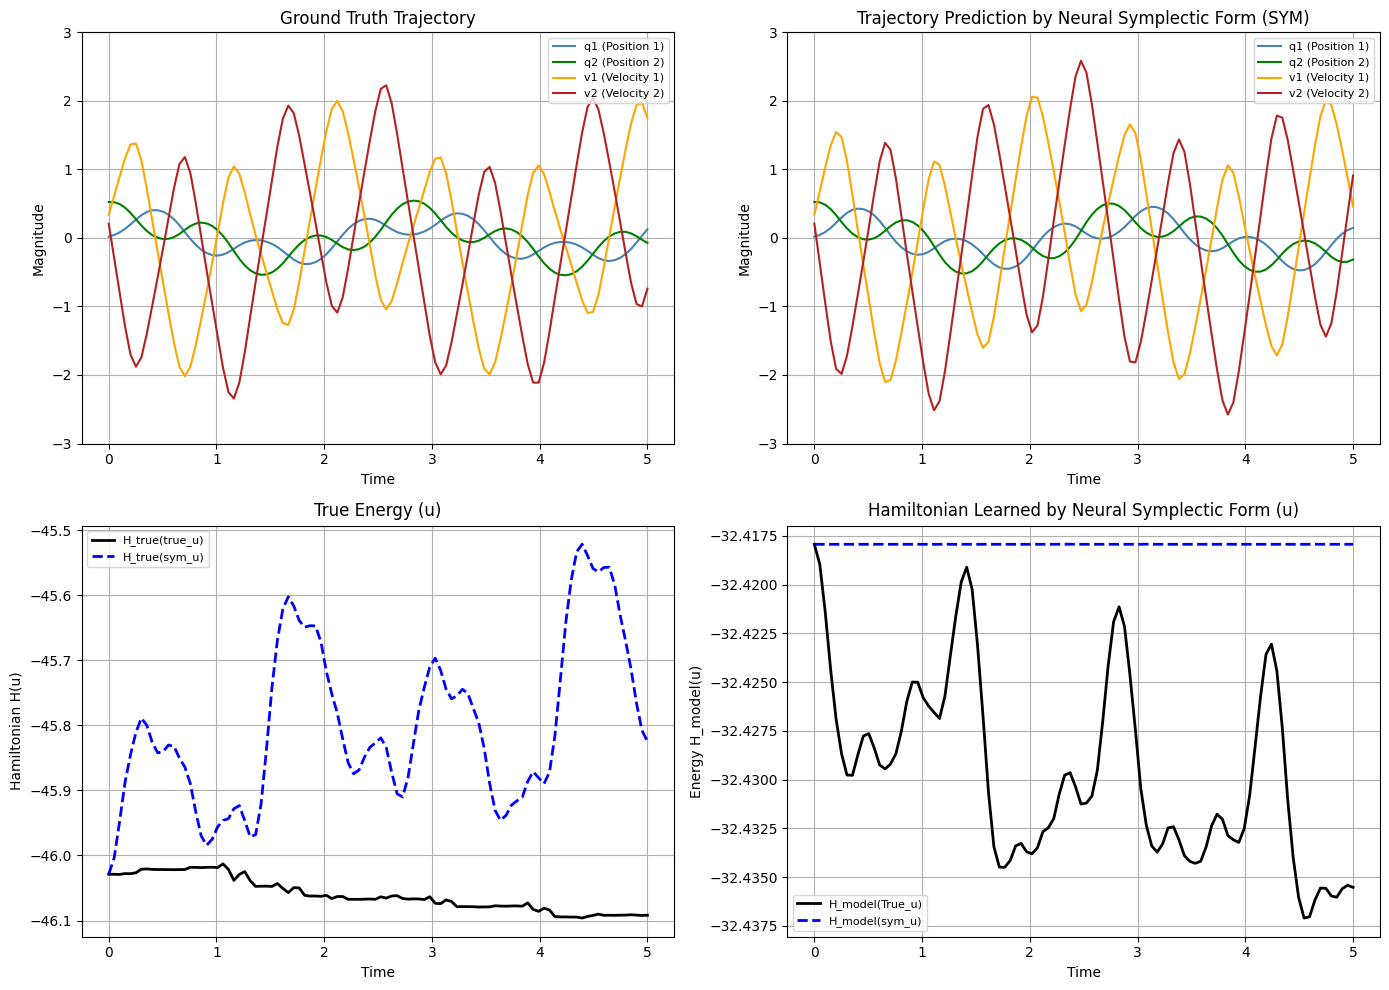

In [13]:
plot_2x2_analysis(true_res, res, t_eval, Htrue_true_x, Htrue_sym_x, Hmodel_true_x, Hmodel_sym_x)

In [14]:
def save_data(data, model="TRUE", item='orbit', order="0123", t_end=tend, dir = './comparison'): 
    file_path = dir + f'/{model}_dbl_pend_{item}_order_{order}_tend_{t_end}.npy'
    np.save(file_path, data)

    print(f"Data have been saved to {file_path} file successfully.")

In [15]:
save_data(true_res, order="0213")
save_data(res, model="SYM", order="0213")
save_data(Htrue_true_x, model="SYM", item="Htrue_true_u", order="0213")
save_data(Htrue_sym_x, model="SYM", item='Htrue_sym_u', order="0213")
save_data(Hmodel_true_x, model="SYM", item='Hmodel_true_u', order="0213")
save_data(Hmodel_sym_x, model="SYM", item='Hmodel_sym_u', order="0213")

Data have been saved to ./comparison/TRUE_dbl_pend_orbit_order_0213_tend_5.0.npy file successfully.
Data have been saved to ./comparison/SYM_dbl_pend_orbit_order_0213_tend_5.0.npy file successfully.
Data have been saved to ./comparison/SYM_dbl_pend_Htrue_true_u_order_0213_tend_5.0.npy file successfully.
Data have been saved to ./comparison/SYM_dbl_pend_Htrue_sym_u_order_0213_tend_5.0.npy file successfully.
Data have been saved to ./comparison/SYM_dbl_pend_Hmodel_true_u_order_0213_tend_5.0.npy file successfully.
Data have been saved to ./comparison/SYM_dbl_pend_Hmodel_sym_u_order_0213_tend_5.0.npy file successfully.
